<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Author: Unknown_

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# often necessary b/c pandas & statsmodels datetime issue
import warnings
warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [2]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [3]:
walmart.shape

(421570, 5)

In [7]:
len(walmart['Store'].unique())


45

In [8]:
len(walmart['Dept'].unique())



81

**Creating a datetime index**

Convert the `Date` column to datetime, and set it as the index for the dataframe.

In [9]:
walmart['Date'] = pd.to_datetime(walmart['Date'])

In [10]:

walmart.set_index('Date', inplace=True,drop=True)


**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **groupby**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [11]:
# Create weekly sales for store 1
walmart[walmart['Store'] == 1].groupby(['Date'])[['Weekly_Sales']].sum().head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

In [12]:
#Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store

walmart[walmart['Store'] == 1].groupby(['Date'])[['Weekly_Sales']].sum().head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [13]:
# Define store_1
store_1 = walmart[walmart['Store'] == 1].groupby(['Date'])[['Weekly_Sales']].sum()

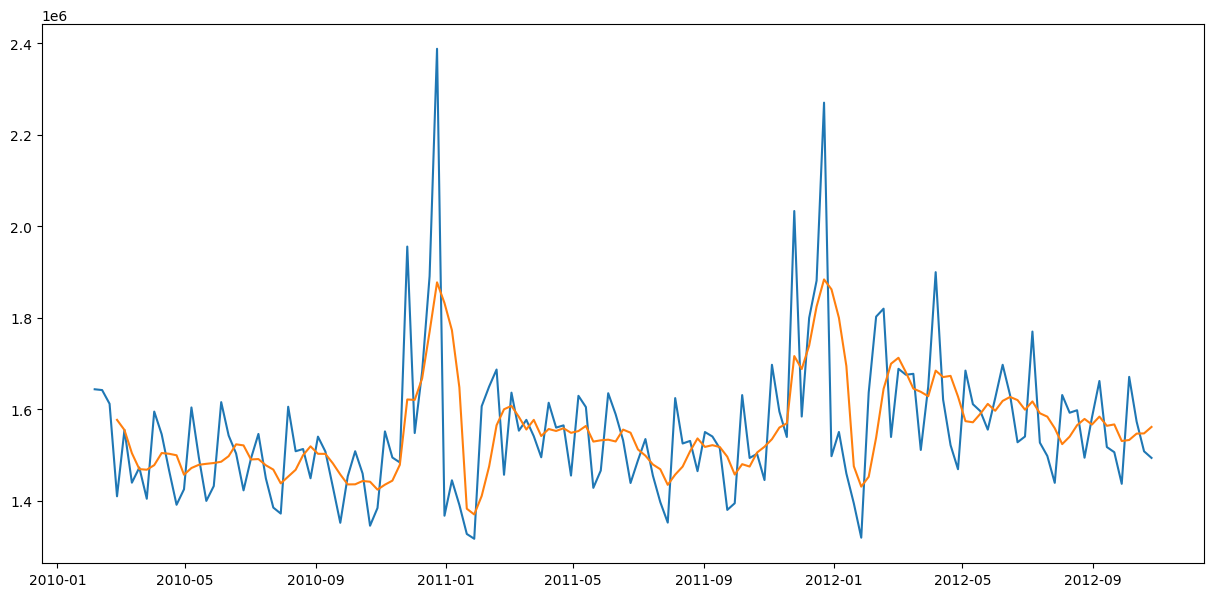

In [14]:
plt.figure(figsize=(15, 7))

plt.plot(store_1.Weekly_Sales, label='Weekly Sales')
plt.plot(store_1.Weekly_Sales.rolling(4).mean());

**One general trend I see is that there seems to be a sharp increase in Weekly Sales around the end of the year, as can be seen in the above chart.
Another general trend is that there is a sharp decrease in Weekly Sales around the end of January.**

---
**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.



**Describe any trends that you notice**

# A: 

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.


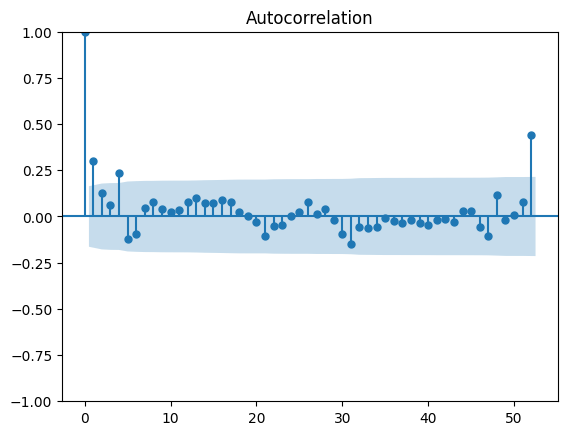

In [17]:

plot_acf(store_1, lags = 52);

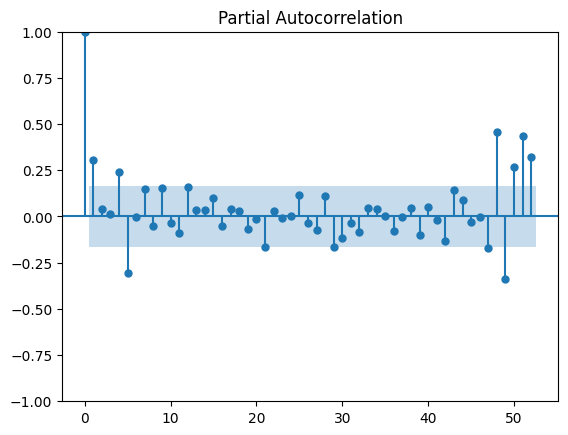

In [18]:
plot_pacf(store_1, lags = 52);

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [36]:
y_train, y_test = train_test_split(store_1, 
                                   test_size= 0.10,
                                   shuffle=False)

---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.**

In [42]:
ar1 =  ARIMA(endog=train['Weekly_Sales'], order=(1, 0, 0))

In [43]:
model = ar1.fit()

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [44]:
preds = model.predict(start="2012-07-20", end="2012-10-26")

In [45]:
from sklearn.metrics import mean_absolute_error

In [47]:

mean_squared_error(y_test, preds)

5026023273.956843

In [48]:
mean_squared_error(y_test, preds, squared=False)

70894.45164437655

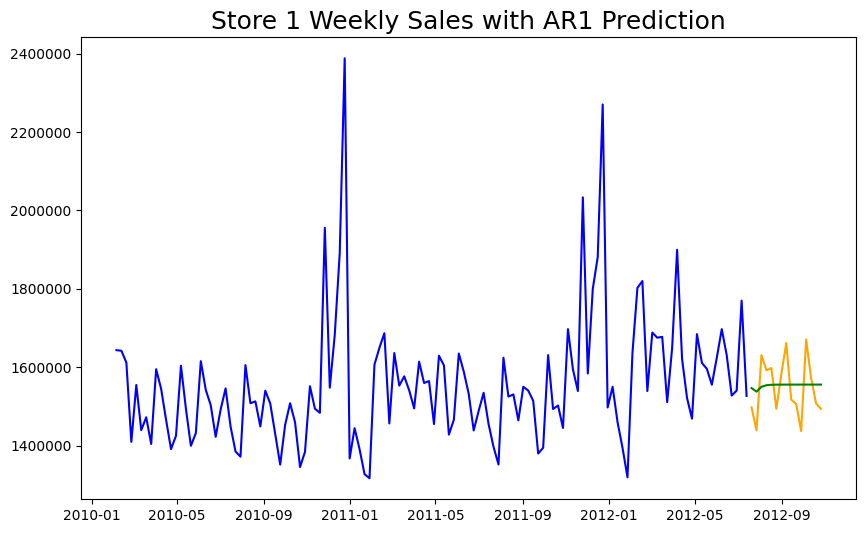

In [53]:
# Plot data
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with AR1 Prediction', fontsize=18)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0)); # Remove scientific notation on y-axis
plt.show();

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of `start` and `end` dates.

Generate and store predictions for the training and testing data.

**Mean squared error**

Use the `mean_squared_error` function to identify the MSE on the testing data.

**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [56]:
ar2 =  ARIMA(endog=train['Weekly_Sales'], order=(2, 0, 2))

In [58]:
# ar2 =  ARIMA(endog=train['Weekly_Sales'], order=(2, 0, 2))
model_ar2 = ar2.fit()
preds_ar2 = model_ar2.predict(start="2012-07-20", end="2012-10-26")


### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [60]:
mean_absolute_error(y_test, preds_ar2)


57157.33991946473

**Mean squared error**

Find the MSE of the testing data.

In [61]:
mean_absolute_error(y_test, preds_ar2)

57157.33991946473

**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

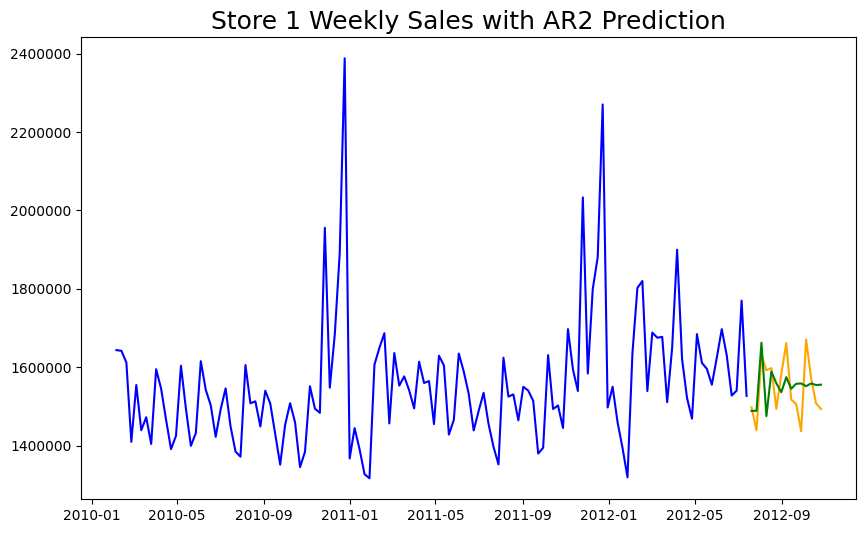

In [63]:
# Plot data
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds_ar2, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with AR2 Prediction', fontsize=18)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0)); # Remove scientific notation on y-axis
plt.show();

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [71]:
# A: 

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [66]:
arma2 =  ARIMA(endog=train['Weekly_Sales'], order=(2, 1, 2))

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [65]:
model_arma2 = arma2.fit()
preds_arma2 = model_arma2.predict(start="2012-07-20", end="2012-10-26")


**Mean squared error**

Find the MSE on your testing data.

In [68]:
mean_absolute_error(y_test, preds_arma2)

71713.37354894518

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

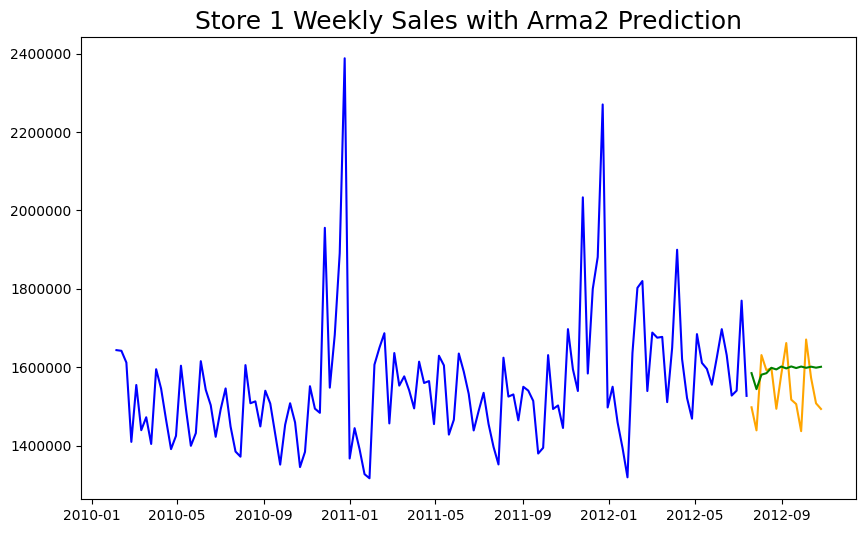

In [70]:
# Plot data
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds_arma2, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with Arma2 Prediction', fontsize=18)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0)); # Remove scientific notation on y-axis
plt.show();

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [5]:
# A:

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [72]:
ar3 =  ARIMA(endog=train['Weekly_Sales'], order=(52, 0, 1))
model_ar3 = ar3.fit()




### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [73]:
preds_ar3 = model_ar3.predict(start="2012-07-20", end="2012-10-26")

**Mean squared error**

Find the MSE on your testing data.

In [74]:
mean_absolute_error(y_test, preds_ar3)

72103.57038072654

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

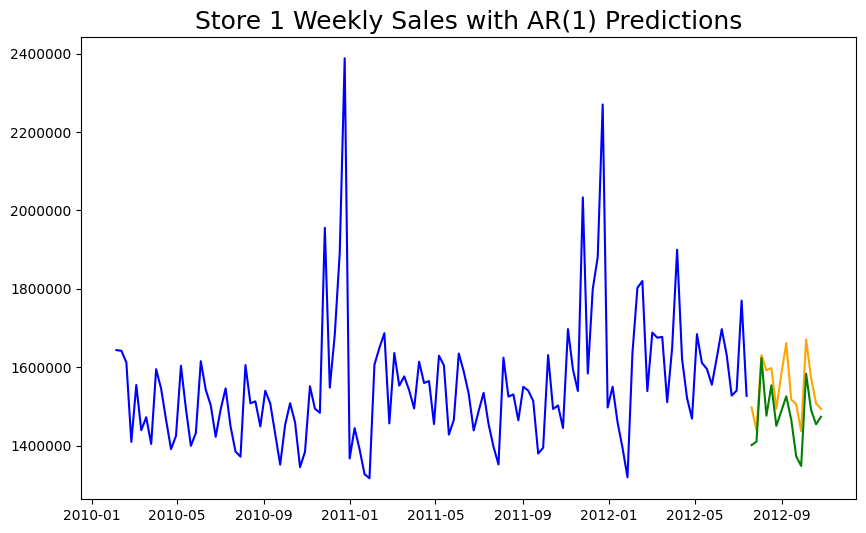

In [75]:
# Plot data
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds_ar3, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with AR(1) Predictions', fontsize=18)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0)); # Remove scientific notation on y-axis
plt.show();


**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [4]:
# A: 

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

In [76]:
sarima = SARIMAX(endog=train['Weekly_Sales'],
                 order=(2, 0, 2),              # (p, d, q)
                  seasonal_order=(1, 1, 1, 52)) # (P, D, Q, S)

model_sarima = sarima.fit()
preds_sarima = model_sarima.predict(start="2012-07-20", end="2012-10-26")
mean_absolute_error(y_test, preds_sarima)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70379D+00    |proj g|=  5.52261D+00

At iterate    5    f=  7.62146D+00    |proj g|=  7.88989D-01

At iterate   10    f=  7.61264D+00    |proj g|=  3.55701D-01

At iterate   15    f=  7.54956D+00    |proj g|=  5.36033D-01

At iterate   20    f=  7.51415D+00    |proj g|=  3.31014D-01

At iterate   25    f=  7.50071D+00    |proj g|=  9.05187D-02

At iterate   30    f=  7.49584D+00    |proj g|=  3.12422D-02

At iterate   35    f=  7.49389D+00    |proj g|=  1.72455D-02

At iterate   40    f=  7.49347D+00    |proj g|=  6.64484D-03

At iterate   45    f=  7.49173D+00    |proj g|=  7.66036D-03

At iterate   50    f=  7.49137D+00    |proj g|=  9.39062D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

35448.537696138555

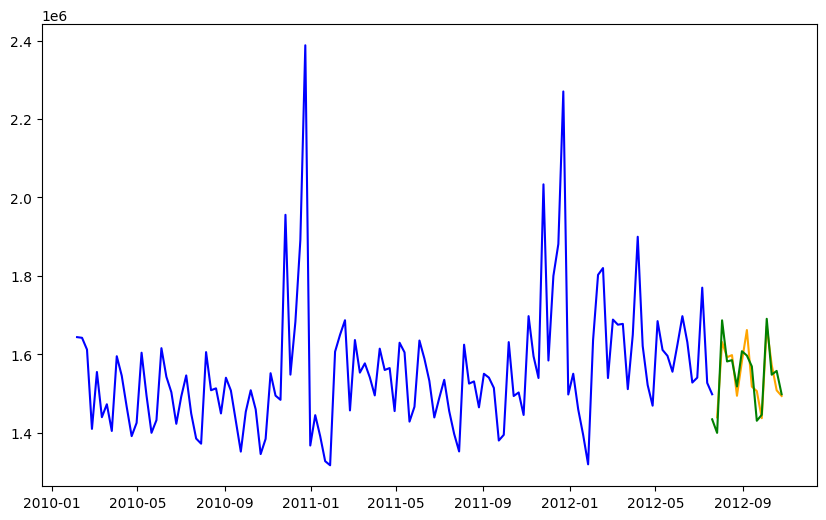

In [77]:
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['Weekly_Sales'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['Weekly_Sales'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds_sarima, color = 'green')

#plt.title(label = 'DOW Monthly Volume', fontsize=18)
plt.show();